In [74]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
from plotnine import ggplot, aes, geom_line, geom_bar, theme, element_blank, element_line, element_text, coord_flip, scale_y_continuous, labs, scale_fill_manual, ggsave, scale_x_continuous
from mizani.formatters import number_format


In [75]:

colors = mcolors.TABLEAU_COLORS

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']


In [76]:


os.chdir('C:/Repos/payment_method_case_if') 

imp = pd.read_excel("PaymentCasefromFinland_data.xlsx")

In [77]:


#sanity check 'grouped values': har jag förstått datan rätt. en rad per kombination av variabelutfall och 'customers' anger hur många med den kombinationen?
sc_grouped = imp.drop(columns = ['customers']).drop_duplicates()

print(len(sc_grouped) - len(imp)) # finns bara distinkta kombinationer av värden

grunddata = (imp
             .assign(Users = lambda x: np.where(x['FeatureInvestigated'] == 1, 'Användare', 'Övriga'),
                     Rating = lambda x: x['Rating'].str.title())
             )


0


In [78]:

def custom_theme(): 
    return (theme(
        panel_background=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major_y=element_line(color="grey"),
        axis_title=element_text(size=14),
         text = element_text(family='Carlito', size = 12)
    ))

def leaning_text():
    return (theme(
        axis_text_x=element_text(angle=45, hjust=1)
    ))

andel_lab = 'Andel i %'


In [79]:

#Slide 1: Vilka åldrar använder metoden? KODGRANSKAD CHECK
by_age_df = (
    grunddata.query('FeatureInvestigated == 1')
    .groupby(['AgeClass'])
    .agg(Antal = ('customers', 'sum'))
    .reset_index()
    .assign(Andel = lambda x: x['Antal'].transform(lambda y:100*y/y.sum()))
    .assign(AgeClass = lambda x: pd.Categorical(x['AgeClass'],
                                                          categories=['Missing', 'Group1', 'Group2', 'Group3', 'Group4'],
                                                          ordered=True))
    )

plt_age = (ggplot(by_age_df) +
           aes(x='AgeClass', y='Andel') +
           geom_bar(stat = 'identity', fill = colors['tab:purple']) +
           custom_theme() +
           theme(axis_title_x = element_blank())+
          labs(y=andel_lab) +
           leaning_text()
          )

print(by_age_df)

  AgeClass  Antal      Andel
0   Group1     68   0.154052
1   Group2    761   1.724021
2   Group3   3919   8.878367
3   Group4  39285  88.998890
4  Missing    108   0.244670


In [89]:
#slide 2 påverkar rating benägenheten? KODGRANSKAD CHECK

rating_df = (
    grunddata.groupby(['Rating', 'Users'])
    .agg(Antal = ('customers', 'sum'))
    .reset_index()
    .assign(Andel = lambda x: x.groupby(['Users'])['Antal'].transform(lambda y:100*y/y.sum()))
    .assign(Rating = lambda x:pd.Categorical(x['Rating'],
                                             categories=['Missing', 'Ok', 'Good', 'Star']))
    .assign(Andel = lambda x:np.where(x['Users'] == 'Övriga', -x['Andel'], x['Andel']))
)

plt_rating = (ggplot(rating_df) +
              aes(x='Rating', y='Andel', fill='Users') + 
              geom_bar(stat='identity', position='identity') +
              leaning_text() +
              coord_flip() +
              custom_theme() +
              theme(axis_title_x = element_blank(),
                   legend_title = element_blank()) +
              scale_y_continuous(labels=lambda x: [abs(v) for v in x]) +
              labs(y=andel_lab) +
              scale_fill_manual(values = ['tab:pink', 'tab:blue']) 
             )

In [93]:
# slide 3: cube rating bland användare och övriga KODGRANSKAD CHECK

cube_level_df = (
    grunddata.groupby(['Users', 'cube_level'])
    .agg(Antal = ('customers', 'sum'))
    .reset_index()
    .assign(Andel = lambda x: x.groupby('Users')['Antal'].transform(lambda y: 100*y/y.sum()))
    .assign(cube_level = lambda x: pd.Categorical(x['cube_level'],
                                                  categories=['?', 0, 1, 2, 3]))
    .assign(Andel = lambda x: np.where(x['Users'] == 'Övriga', -x['Andel'], x['Andel']))
    )

plt_cube_level = (ggplot(cube_level_df) +
              aes(x='cube_level', y='Andel', fill='Users') +
              geom_bar(stat='identity', position ='identity') +
              coord_flip() +
              scale_fill_manual(values=['tab:pink', 'tab:blue']) +
             scale_y_continuous(labels=lambda x: [abs(v) for v in x]) +  #
              custom_theme() +
              theme(legend_title = element_blank()) +
                  labs(x='Cube level', y=andel_lab)
)

#Beräknar snitt
"""cube_level_df_weight = cube_level_df
cube_level_df_weight['cube_level'] = cube_level_df_weight['cube_level'].replace('?', None).astype(float)

def weighted_mean(group):
    return (group['cube_level'] * group['Antal']).sum() / group['Antal'].sum()

weighted_means = cube_level_df_weight.groupby('Users').apply(weighted_mean).reset_index(name='Weighted Mean')"""

print(cube_level_df)

       Users cube_level   Antal      Andel
0  Användare          0     810   1.835029
1  Användare          1    8328  18.866813
2  Användare          2    6749  15.289640
3  Användare          3    4761  10.785891
4  Användare          ?   23493  53.222627
5     Övriga          0  101247 -11.814905
6     Övriga          1  259608 -30.294664
7     Övriga          2   86365 -10.078267
8     Övriga          3  177343 -20.694842
9     Övriga          ?  232380 -27.117323


In [82]:
#dataframe 4: contact KODGRANSKAD CHECK

email_df = (
    grunddata.groupby(['Users'])
    .apply(lambda x: (x['contact_info_edm']*x['customers']).sum() / x['customers'].sum())
    .reset_index(name='Email')
)

telefon_df = (
    grunddata.groupby(['Users'])
    .apply(lambda x: (x['contact_info_tm']*x['customers']).sum() /x['customers'].sum())
    .reset_index(name='Telefon')
          )
                       
contact_df = (
    pd.merge(email_df, telefon_df, on='Users')
    .melt(id_vars=['Users'], value_vars=['Email', 'Telefon'], var_name='Kontaktinfo', value_name='Andel')
    .assign(Andel = lambda x: x['Andel']*100)
)

plt_contact = (
    ggplot(contact_df) +
    aes(x='Kontaktinfo', y='Andel', fill='Users') +
    geom_bar(stat='identity', position='dodge') +
    custom_theme() +
    theme(legend_title = element_blank(),
         axis_title_x = element_blank()) +
    scale_fill_manual(values = ['tab:pink', 'tab:blue']) +
    labs(y=andel_lab) +
    leaning_text()
    )

C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\1893715443.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\1893715443.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [83]:
#duration KODGRANSKNING KLAR

duration_df = (
    grunddata.groupby(['DurationClass', 'Users'])
    .agg(Antal = ('customers', 'sum'))
    .reset_index()
    .assign(Andel = lambda x: x.groupby('Users')['Antal'].transform(lambda y: 100*y/y.sum()),
           Duration = lambda x: pd.Categorical(x['DurationClass']
                .astype(str)
            .str.replace('to', 'till ', regex=False)
            .str.replace(r'\s+', ' ', regex=True),
           categories=['0', '1', '2', '3', '4', '5 till 6', '7 till 9', '10 till 14', '15 till 19', '20 till 29', '30+', 'Missing'],
           ordered=True))
    .assign(Andel = lambda x: np.where(x['Users'] == 'Övriga', -x['Andel'], x['Andel']))
    )

plt_duration = (
    ggplot(duration_df, aes(x='Duration', y='Andel', fill='Users')) +
    geom_bar(stat='identity', position='identity') +
    coord_flip() +
    custom_theme() +
    theme(legend_title = element_blank()
          ) +
    labs(x = 'Antal år som kund', y = andel_lab) +
    scale_fill_manual(values=['tab:pink', 'tab:blue'])
    )

In [84]:
# products KODGRANSKAT

products_binary = (
    grunddata.assign(
        **{f'binary_{product}': (grunddata[product]>0).astype(int) for product in ['product1', 'product2', 'product3', 'product4']})
)

product_cols = ['product1', 'product2', 'product3', 'product4','binary_product1', 'binary_product2', 'binary_product3', 'binary_product4']

products_df = (
    products_binary.assign(**{product: products_binary[product] * products_binary['customers'] for product in product_cols}) 
    .loc[products_binary['Users'] == 'Användare', product_cols]
    .sum(numeric_only=True)
    .reset_index()
)

products_df.columns = ['name', 'value']

products_df = (
    products_df.assign(ProductNo = lambda x: x['name'].str[-1],
                      Type = lambda x: x['name'].str[:-1])
)

plt_products = (
    ggplot(products_df, aes(x='ProductNo', y='value', fill='Type')) +
    geom_bar(stat='identity', position='dodge') +
    custom_theme() +
    scale_fill_manual(values=['tab:olive', 'tab:red'], labels =['Antal unika kunder', 'Antal produkter']) +
    scale_y_continuous(labels=number_format(big_mark=" ")) +
    labs(y='Antal')
    )


In [90]:
plots = {'plt_age':plt_age,
        'plt_rating':plt_rating,
        'plt_contact':plt_contact,
        'plt_duration':plt_duration,
        'plt_cube_level':plt_cube_level,
        'plt_products':plt_products}



C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


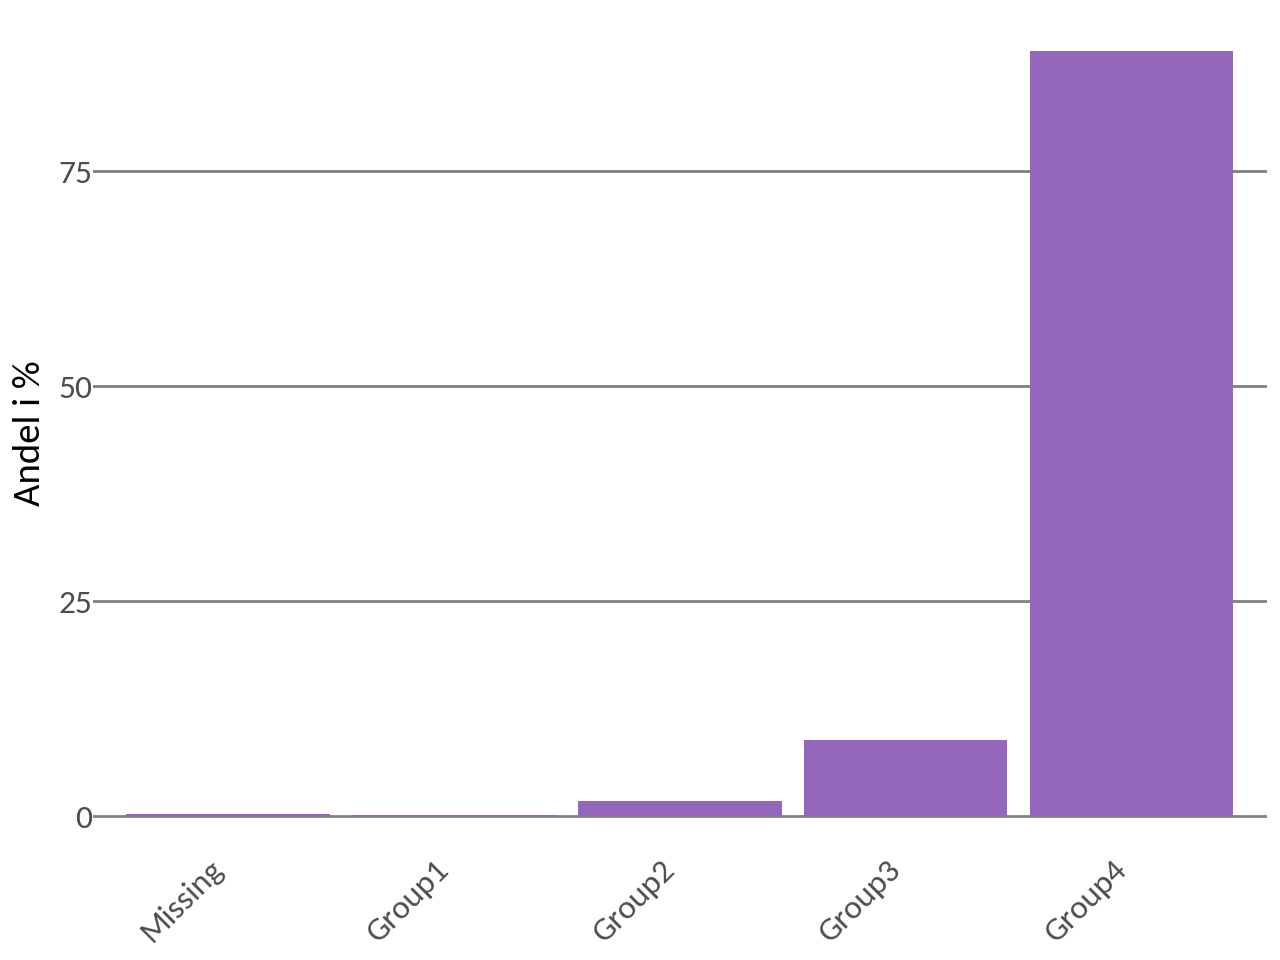

('plt_age', <Figure Size: (640 x 480)>)


C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


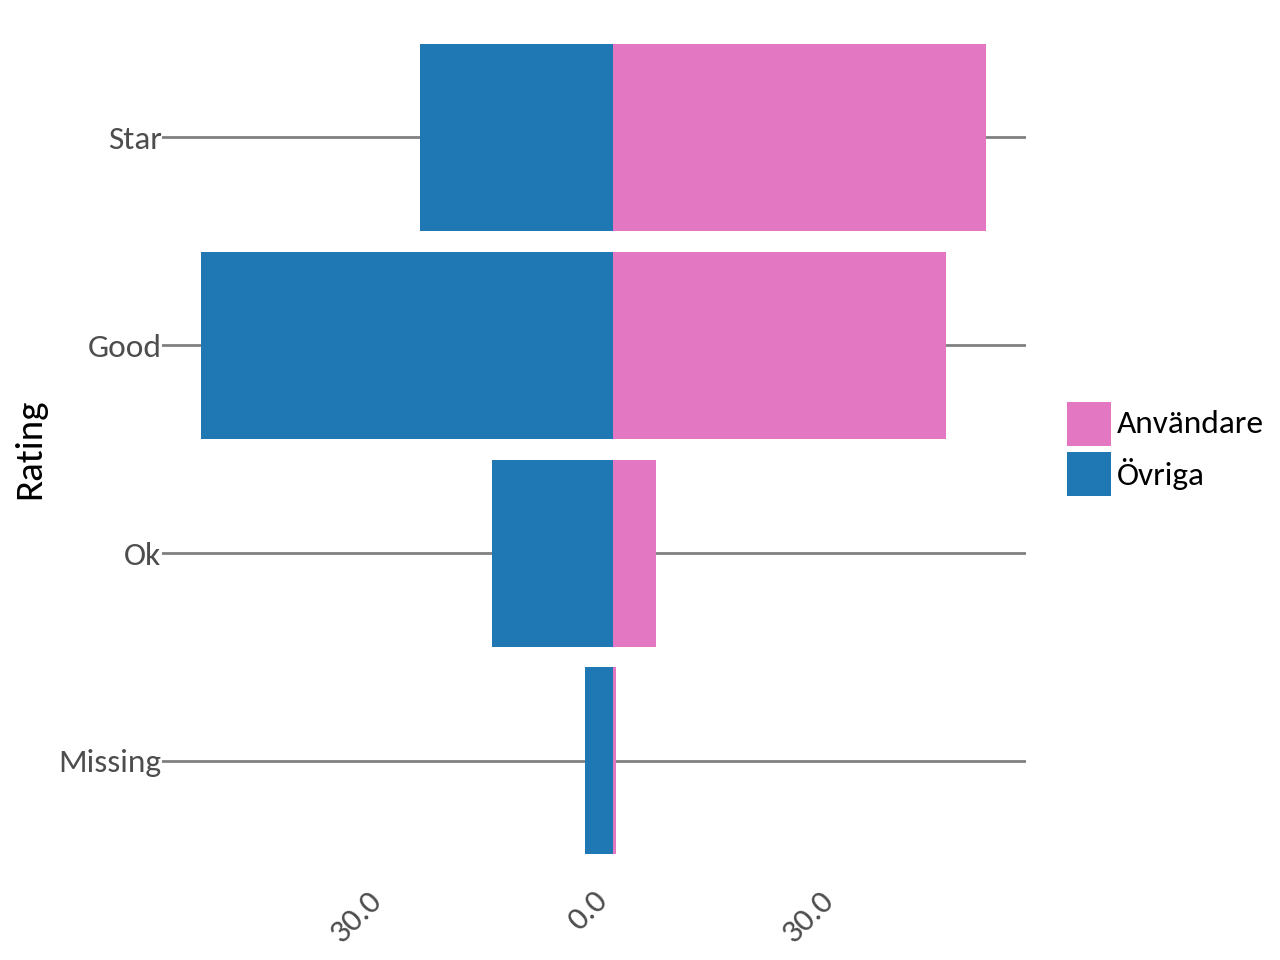

('plt_rating', <Figure Size: (640 x 480)>)


C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


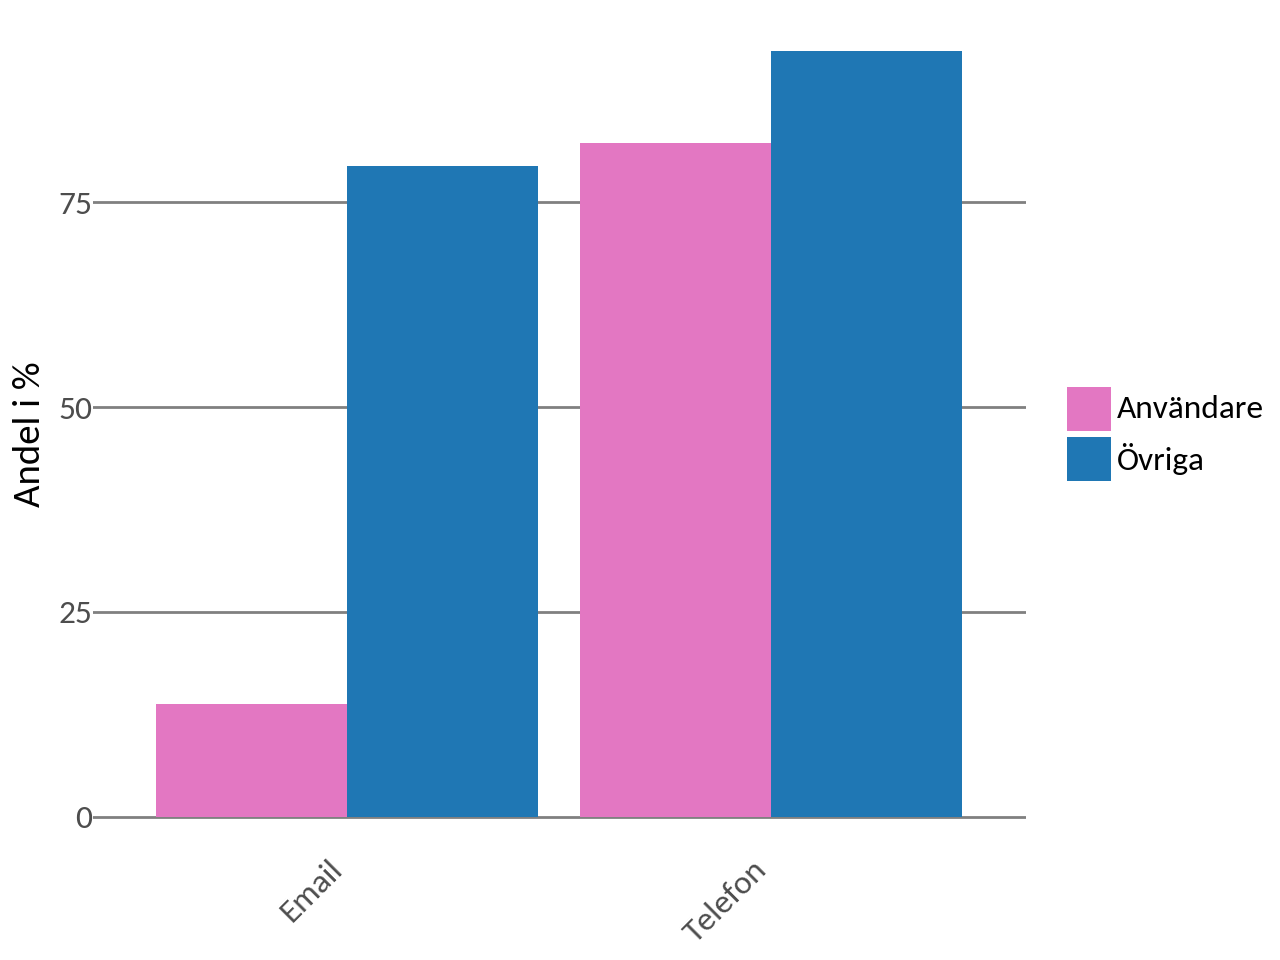

('plt_contact', <Figure Size: (640 x 480)>)


C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


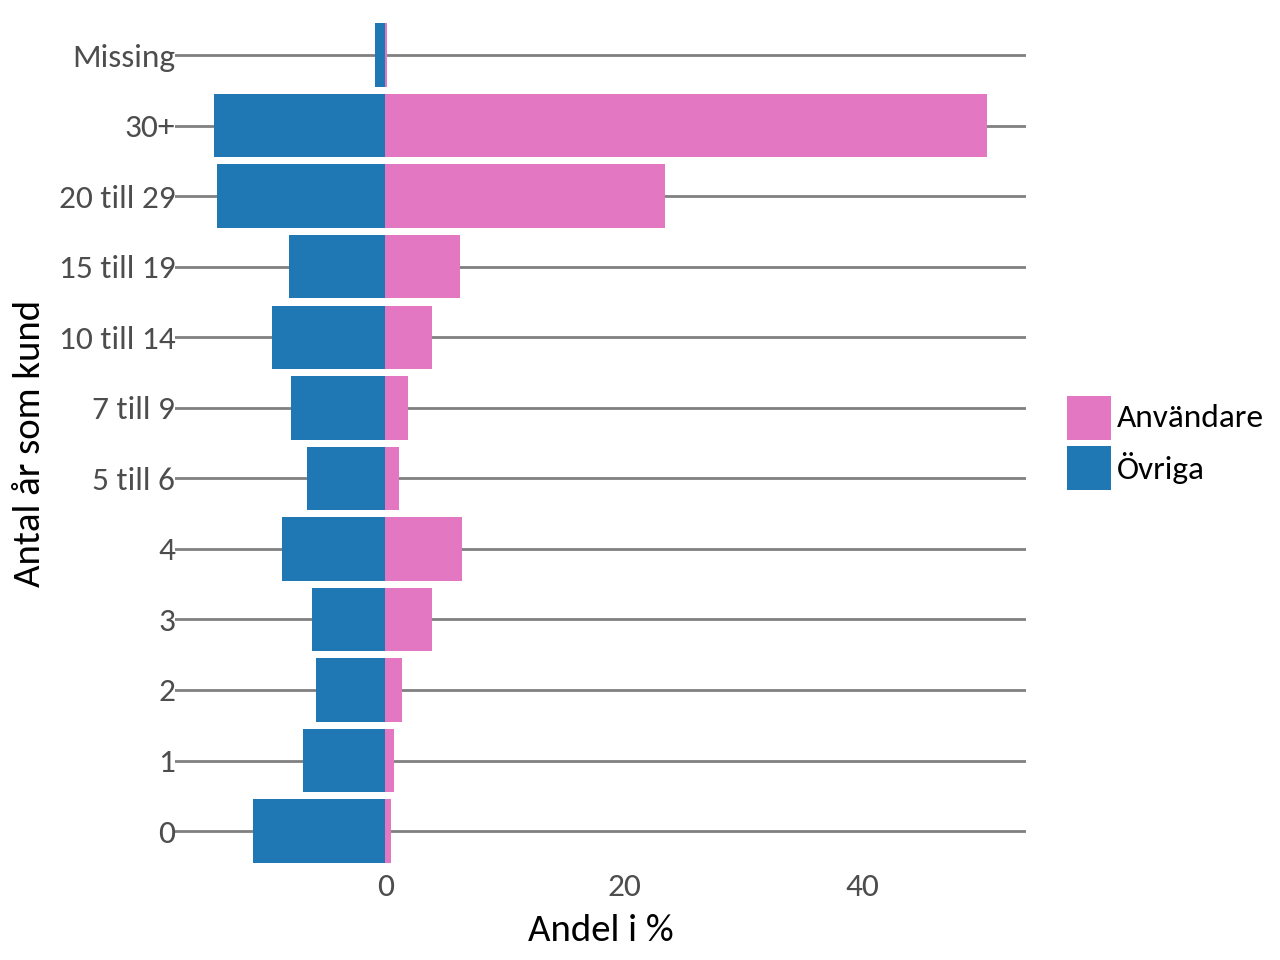

('plt_duration', <Figure Size: (640 x 480)>)


C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


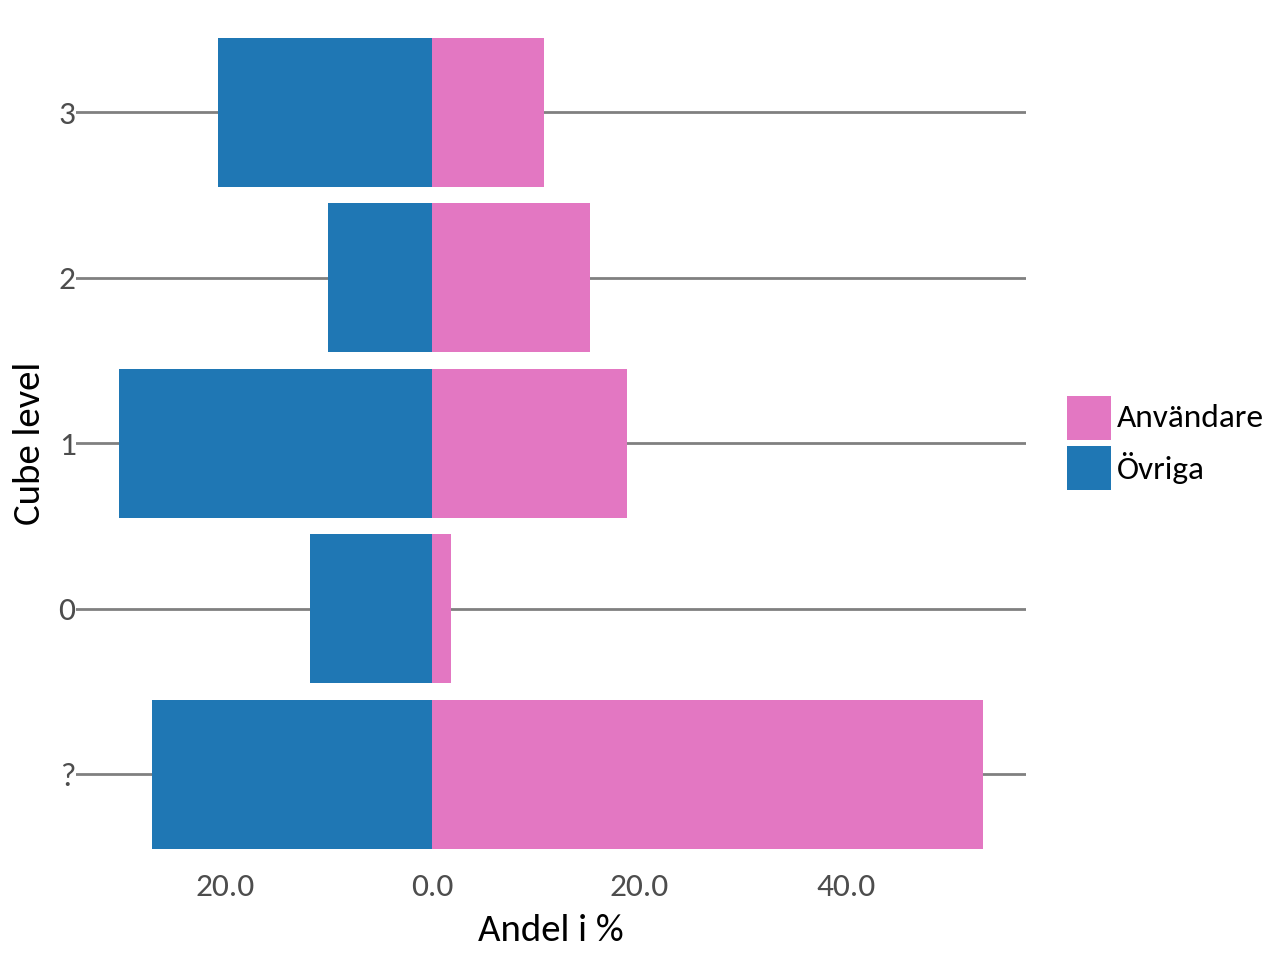

('plt_cube_level', <Figure Size: (640 x 480)>)


C:\Users\WilliamIDalen\AppData\Local\Temp\ipykernel_9240\3678088999.py:2: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


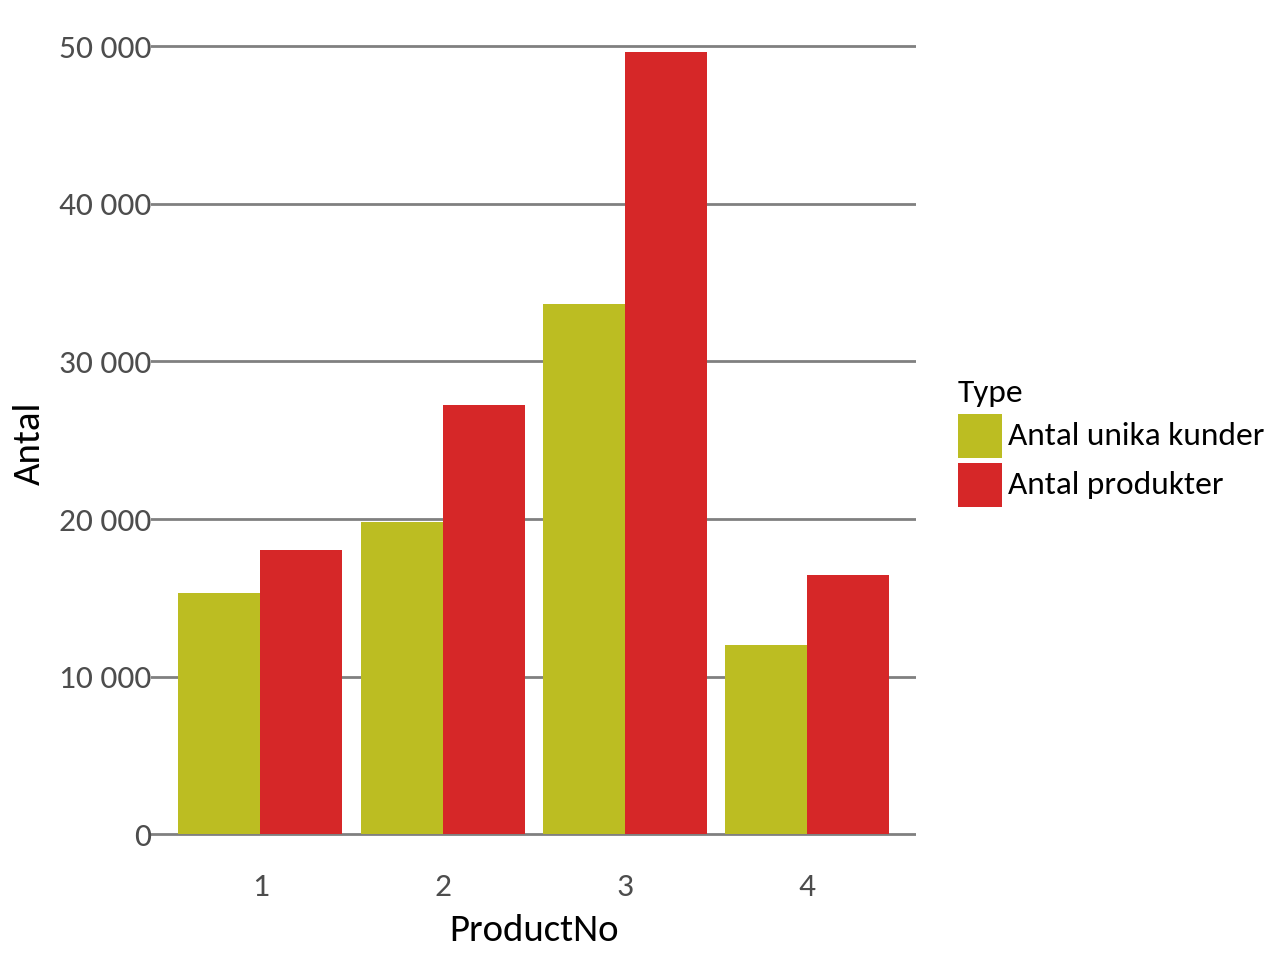

('plt_products', <Figure Size: (640 x 480)>)


In [91]:
for plot in plots.items():
    print(plot)

In [92]:
# export

for name, plot in plots.items():
    filename = f"plots/{name}.pdf"
    ggsave(plot, filename=filename, dpi=300)


C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: plots/plt_age.pdf
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: plots/plt_rating.pdf
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: plots/plt_contact.pdf
C:\Users\WilliamIDalen\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot

In [88]:
## frågor dom lär ställa
### vad hade du velat ha mer för data?
    ###svar: data om hur mycket produkter de faktiskt köper för. SEK expenditures typ. 
    ###data för de andra payment methods. undersöka corr mellan att ha den här och att inte ha testat dom andra
### Antaganden:
    ### verksamheten/mottagarna har en uppfattning om hur Cube level funkar
    ### åldern på användarna är en kohort-/generationseffekt. yngre människor kommer inte börja föredra pappersavier när de blir äldre
    ### 
### avstått ifrån:
    ### undersöka products närmre. hur många köper användare vs icke-användare osv?
    ### undersöka hur ofta om året de betalar
    ### undersöka produkter närmre. hur många köper användare vs icke-användare?
    ### på jobbet hade jag frågat verksamehten :)
    ### kodat mycket snyggare, kommenterat
    ### ytterligare formgivning. typ decimaltecken = ','